In [1]:
#U-Net 2-Plus

In [1]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
from layers import unetConv2, unetUp_origin
from init_weights import init_weights
import numpy as np
from torchvision import models
class UNet_2Plus(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True, is_ds=True):
        super(UNet_2Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.is_ds = is_ds
        self.feature_scale = feature_scale

        # filters = [32, 64, 128, 256, 512]
        filters = [64, 128, 256, 512, 1024]
        # filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv00 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool0 = nn.MaxPool2d(kernel_size=2)
        self.conv10 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv20 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv30 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv40 = unetConv2(filters[3], filters[4], self.is_batchnorm)


        # upsampling
        self.up_concat01 = unetUp_origin(filters[1], filters[0], self.is_deconv)
        self.up_concat11 = unetUp_origin(filters[2], filters[1], self.is_deconv)
        self.up_concat21 = unetUp_origin(filters[3], filters[2], self.is_deconv)
        self.up_concat31 = unetUp_origin(filters[4], filters[3], self.is_deconv)

        self.up_concat02 = unetUp_origin(filters[1], filters[0], self.is_deconv, 3)
        self.up_concat12 = unetUp_origin(filters[2], filters[1], self.is_deconv, 3)
        self.up_concat22 = unetUp_origin(filters[3], filters[2], self.is_deconv, 3)

        self.up_concat03 = unetUp_origin(filters[1], filters[0], self.is_deconv, 4)
        self.up_concat13 = unetUp_origin(filters[2], filters[1], self.is_deconv, 4)

        self.up_concat04 = unetUp_origin(filters[1], filters[0], self.is_deconv, 5)

        # final conv (without any concat)
        self.final_1 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_2 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_3 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_4 = nn.Conv2d(filters[0], n_classes, 1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        # column : 0
        X_00 = self.conv00(inputs)
        maxpool0 = self.maxpool0(X_00)
        X_10 = self.conv10(maxpool0)
        maxpool1 = self.maxpool1(X_10)
        X_20 = self.conv20(maxpool1)
        maxpool2 = self.maxpool2(X_20)
        X_30 = self.conv30(maxpool2)
        maxpool3 = self.maxpool3(X_30)
        X_40 = self.conv40(maxpool3)

        # column : 1
        X_01 = self.up_concat01(X_10, X_00)
        X_11 = self.up_concat11(X_20, X_10)
        X_21 = self.up_concat21(X_30, X_20)
        X_31 = self.up_concat31(X_40, X_30)
        # column : 2
        X_02 = self.up_concat02(X_11, X_00, X_01)
        X_12 = self.up_concat12(X_21, X_10, X_11)
        X_22 = self.up_concat22(X_31, X_20, X_21)
        # column : 3
        X_03 = self.up_concat03(X_12, X_00, X_01, X_02)
        X_13 = self.up_concat13(X_22, X_10, X_11, X_12)
        # column : 4
        X_04 = self.up_concat04(X_13, X_00, X_01, X_02, X_03)

        # final layer
        final_1 = self.final_1(X_01)
        final_2 = self.final_2(X_02)
        final_3 = self.final_3(X_03)
        final_4 = self.final_4(X_04)

        final = (final_1 + final_2 + final_3 + final_4) / 4

        if self.is_ds:
            return F.sigmoid(final)
        else:
            return F.sigmoid(final_4)

model = UNet_2Plus()
print('# generator parameters:', 1.0 * sum(param.numel() for param in model.parameters())/1000000)
params = list(model.named_parameters())
for i in range(len(params)):
    (name, param) = params[i]
    print(name)
    print(param.shape)


# generator parameters: 47.176132
conv00.conv1.0.weight
torch.Size([64, 3, 3, 3])
conv00.conv1.0.bias
torch.Size([64])
conv00.conv1.1.weight
torch.Size([64])
conv00.conv1.1.bias
torch.Size([64])
conv00.conv2.0.weight
torch.Size([64, 64, 3, 3])
conv00.conv2.0.bias
torch.Size([64])
conv00.conv2.1.weight
torch.Size([64])
conv00.conv2.1.bias
torch.Size([64])
conv10.conv1.0.weight
torch.Size([128, 64, 3, 3])
conv10.conv1.0.bias
torch.Size([128])
conv10.conv1.1.weight
torch.Size([128])
conv10.conv1.1.bias
torch.Size([128])
conv10.conv2.0.weight
torch.Size([128, 128, 3, 3])
conv10.conv2.0.bias
torch.Size([128])
conv10.conv2.1.weight
torch.Size([128])
conv10.conv2.1.bias
torch.Size([128])
conv20.conv1.0.weight
torch.Size([256, 128, 3, 3])
conv20.conv1.0.bias
torch.Size([256])
conv20.conv1.1.weight
torch.Size([256])
conv20.conv1.1.bias
torch.Size([256])
conv20.conv2.0.weight
torch.Size([256, 256, 3, 3])
conv20.conv2.0.bias
torch.Size([256])
conv20.conv2.1.weight
torch.Size([256])
conv20.conv2.1

In [2]:
model = UNet_2Plus()
print('# generator parameters:', 1.0 * sum(param.numel() for param in model.parameters())/1000000)
params = list(model.named_parameters())
for i in range(len(params)):
    (name, param) = params[i]
    print(name)
    print(param.shape)

# generator parameters: 47.176132
conv00.conv1.0.weight
torch.Size([64, 3, 3, 3])
conv00.conv1.0.bias
torch.Size([64])
conv00.conv1.1.weight
torch.Size([64])
conv00.conv1.1.bias
torch.Size([64])
conv00.conv2.0.weight
torch.Size([64, 64, 3, 3])
conv00.conv2.0.bias
torch.Size([64])
conv00.conv2.1.weight
torch.Size([64])
conv00.conv2.1.bias
torch.Size([64])
conv10.conv1.0.weight
torch.Size([128, 64, 3, 3])
conv10.conv1.0.bias
torch.Size([128])
conv10.conv1.1.weight
torch.Size([128])
conv10.conv1.1.bias
torch.Size([128])
conv10.conv2.0.weight
torch.Size([128, 128, 3, 3])
conv10.conv2.0.bias
torch.Size([128])
conv10.conv2.1.weight
torch.Size([128])
conv10.conv2.1.bias
torch.Size([128])
conv20.conv1.0.weight
torch.Size([256, 128, 3, 3])
conv20.conv1.0.bias
torch.Size([256])
conv20.conv1.1.weight
torch.Size([256])
conv20.conv1.1.bias
torch.Size([256])
conv20.conv2.0.weight
torch.Size([256, 256, 3, 3])
conv20.conv2.0.bias
torch.Size([256])
conv20.conv2.1.weight
torch.Size([256])
conv20.conv2.1

In [3]:
import torch
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.4
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA RTX A5000


In [4]:
from PIL import Image
from torchvision import transforms
import torch
import os

images_path = "isic2018/train/images"
masks_path = "isic2018/train/masks"

transform_image = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Convert image to tensor
])
transform_mask = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Convert mask to tensor
])

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

dataset = SegmentationDataset(images_path, masks_path, transform_image, transform_mask)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
val_images_path = "isic2018/val/images"
val_masks_path = "isic2018/val/masks"

valset = SegmentationDataset(val_images_path, val_masks_path, transform_image, transform_mask)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=16, shuffle=False)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss() 

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    for epoch in range(epochs):
        model.train() 
        train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval() 
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

Epoch [1/50], Train Loss: 0.6946, Val Loss: 0.6931
Epoch [2/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [3/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [4/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [5/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [6/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [7/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [8/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [9/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [10/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [11/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [12/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [13/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [14/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [15/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [16/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [17/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [18/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [19/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [20/50], Train 

In [9]:
torch.save(model, 'model2.pth')

In [10]:
images_path2 = "isic2017/train/images"
masks_path2 = "isic2017/train/masks"

In [11]:
dataset2 = SegmentationDataset(images_path2, masks_path2, transform_image, transform_mask)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=True)

In [12]:
val_images_path2 = "isic2017/val/images"
val_masks_path2 = "isic2017/val/masks"

valset2 = SegmentationDataset(val_images_path2, val_masks_path2, transform_image, transform_mask)
valloader2 = torch.utils.data.DataLoader(valset2, batch_size=32, shuffle=True)

In [13]:
model.eval()

UNet_2Plus(
  (conv00): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv10): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UNet_2Plus(
  (conv00): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv10): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

In [15]:
train_loss = 0.0
with torch.no_grad():
    for images, masks in dataloader2:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()

average_loss = train_loss/len(dataloader2)

print(f"Test Loss: {average_loss:.4f}")

Test Loss: 0.6931


In [16]:
val_loss = 0.0
with torch.no_grad():
    for images, masks in valloader2:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

average_loss = val_loss/len(valloader2)

print(f"Test Loss: {average_loss:.4f}")

Test Loss: 0.6931


In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
def visualize_segmentation(inputs, labels, outputs, class_names=None):

    input_image = inputs[0].cpu().numpy().transpose((1, 2, 0))  
    ground_truth_mask = np.squeeze(labels[0]).cpu().numpy()  
    predicted_mask = np.squeeze(outputs[0]).cpu().numpy()  

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(input_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(ground_truth_mask, cmap="jet")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(predicted_mask, cmap="jet")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

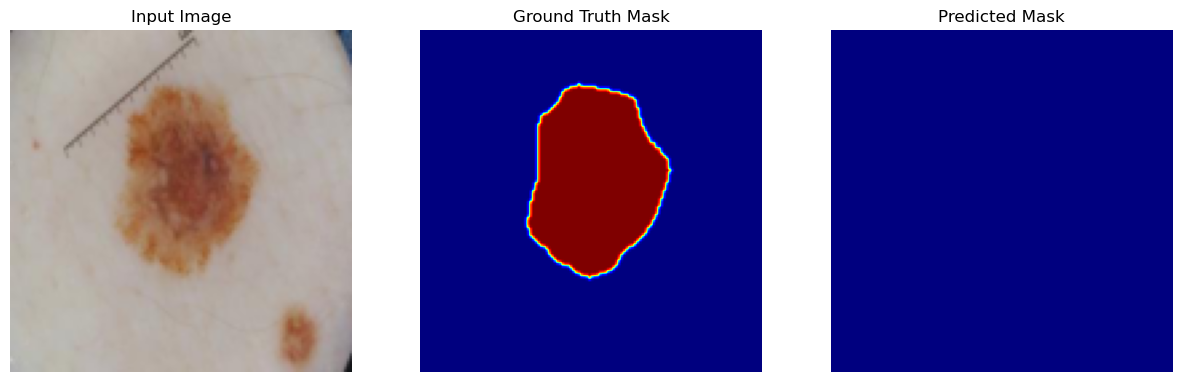

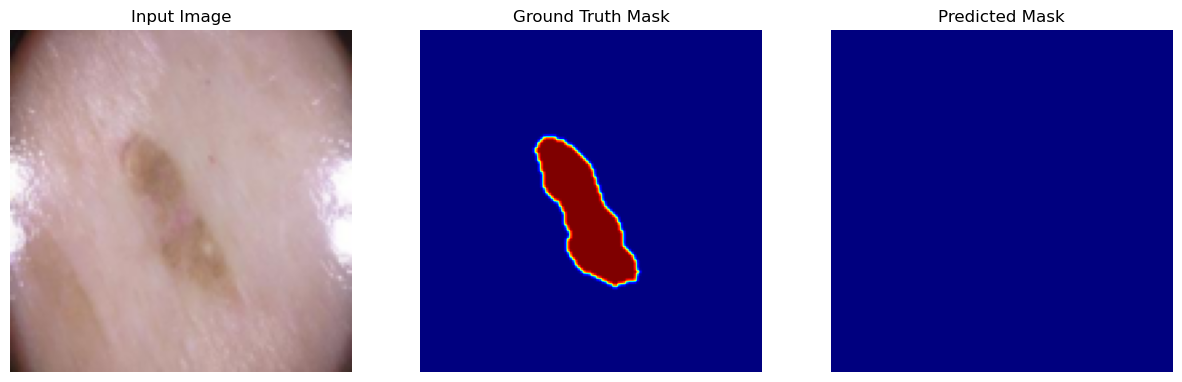

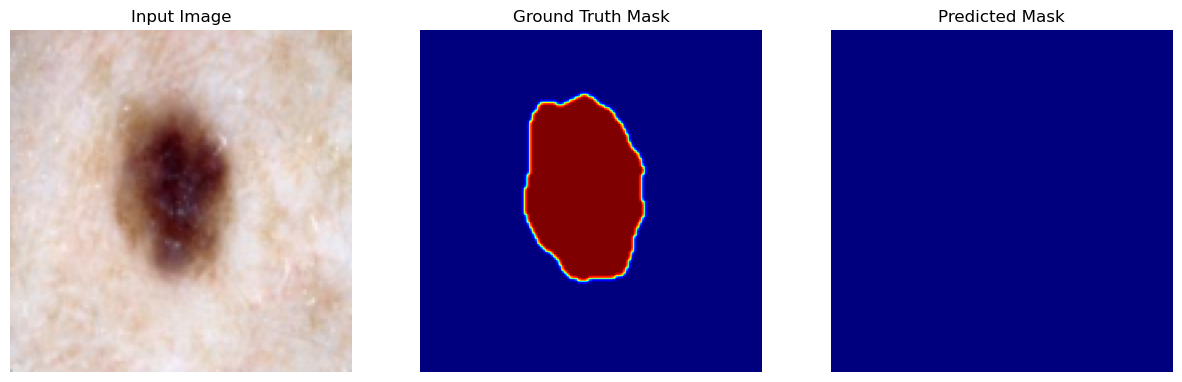

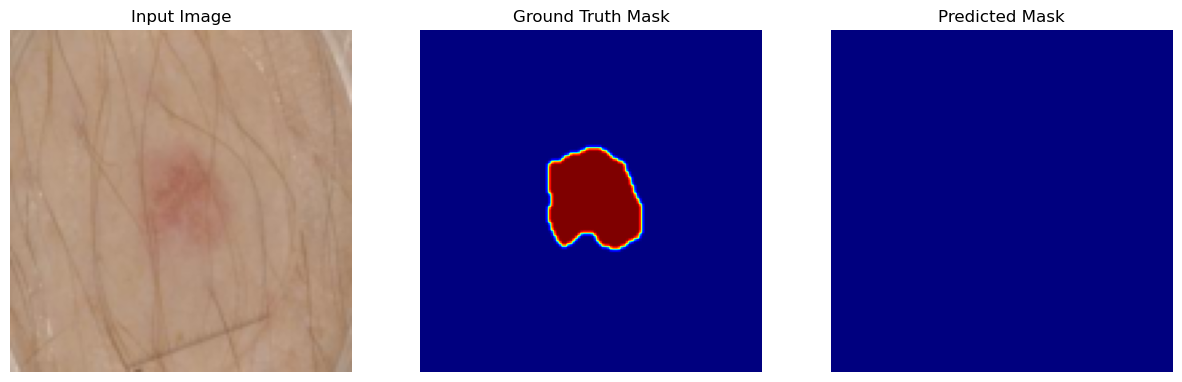

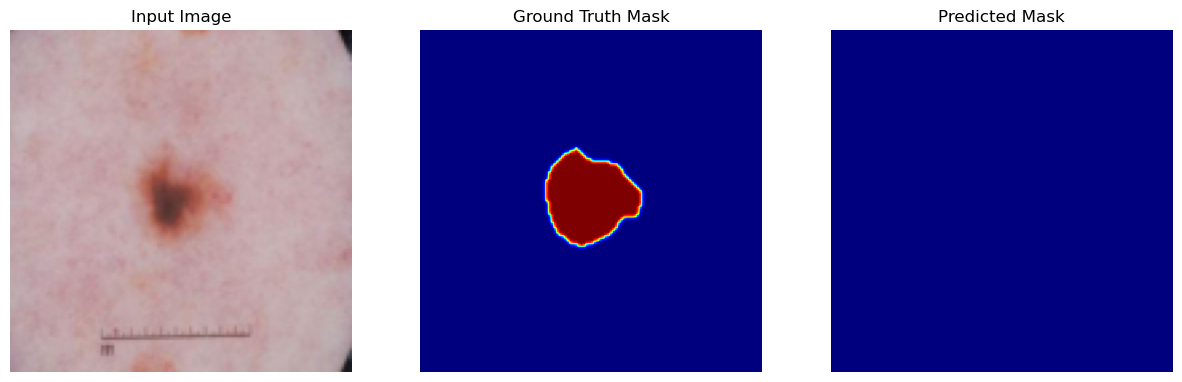

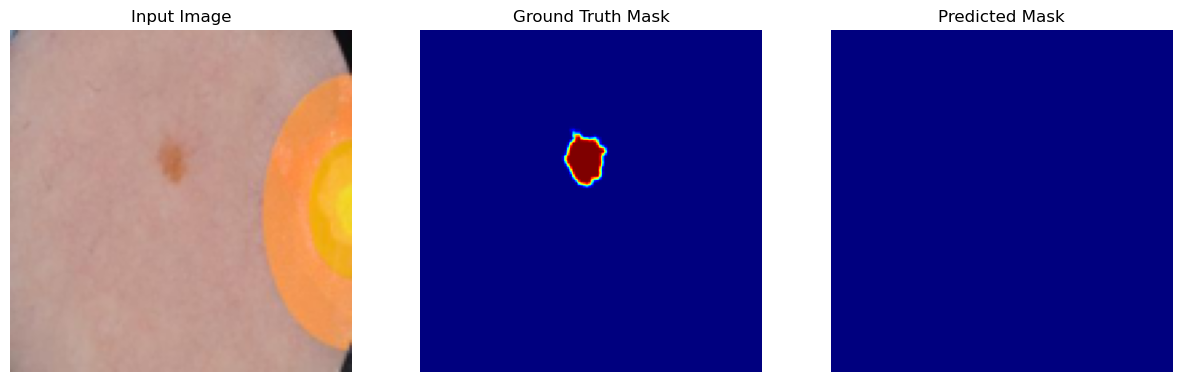

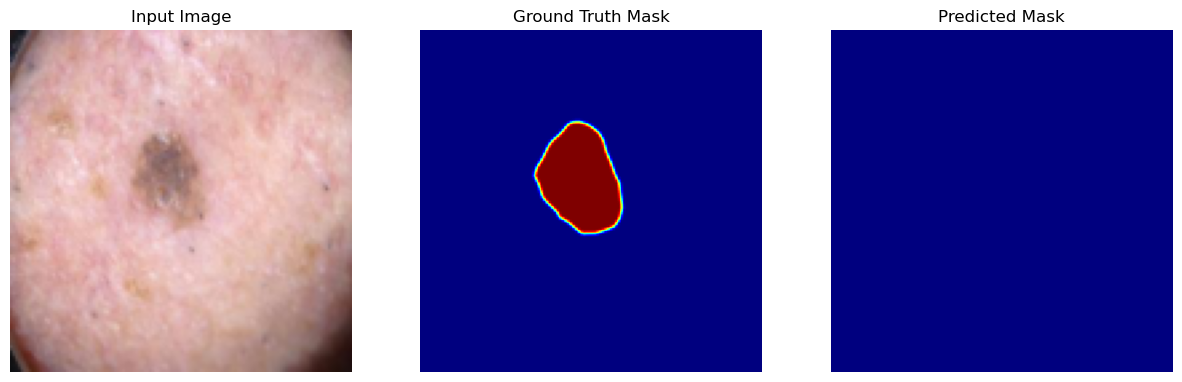

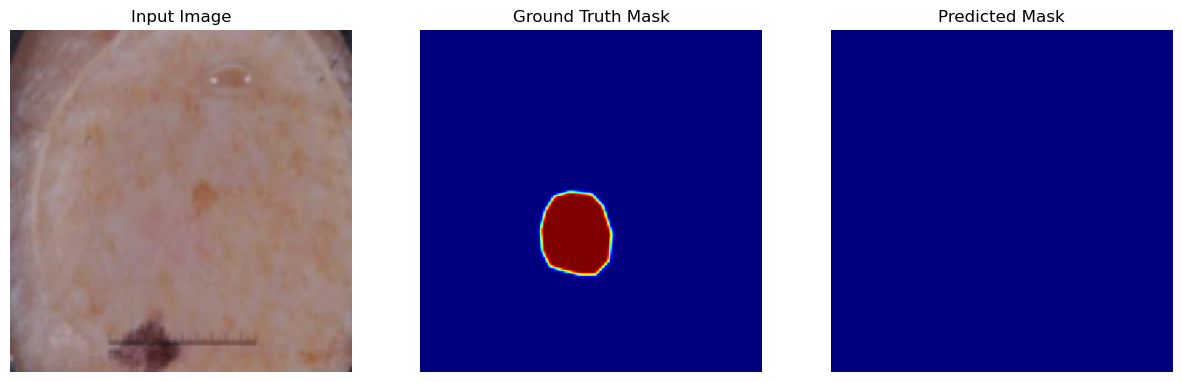

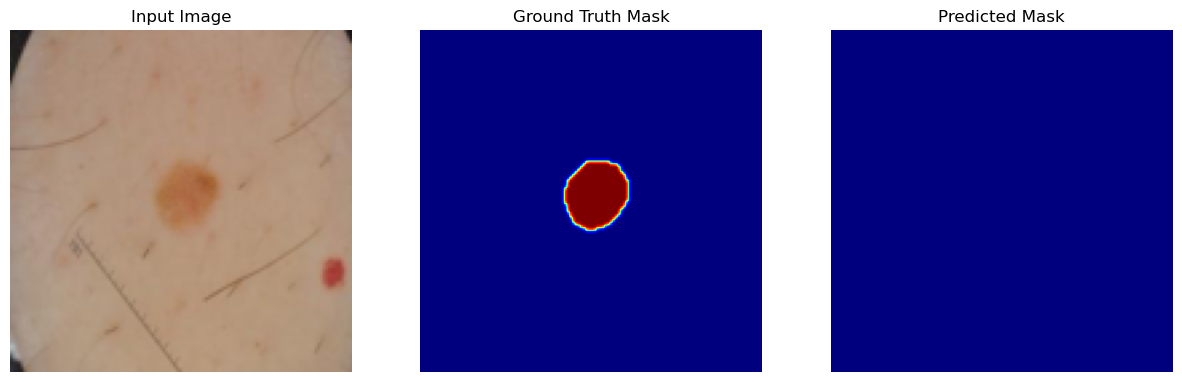

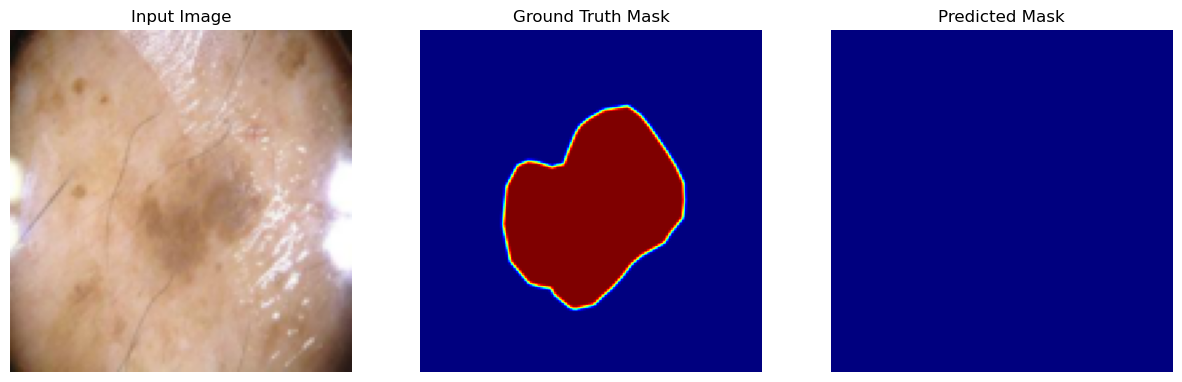

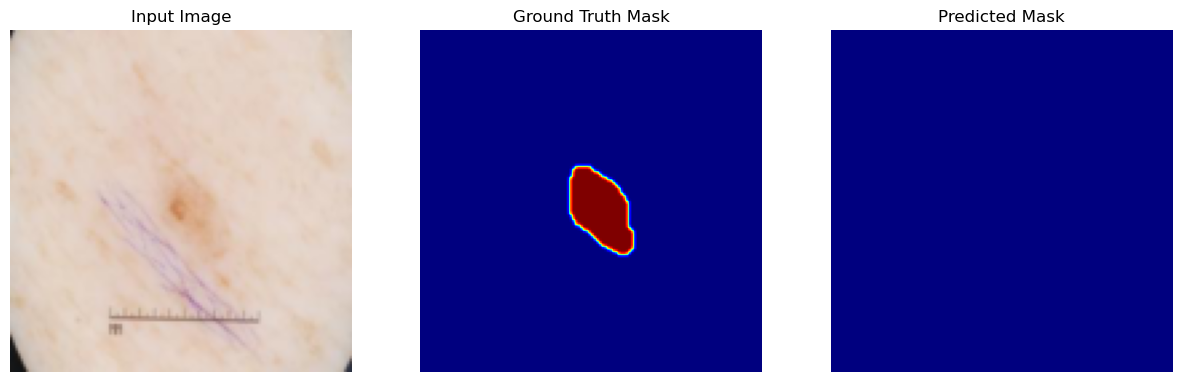

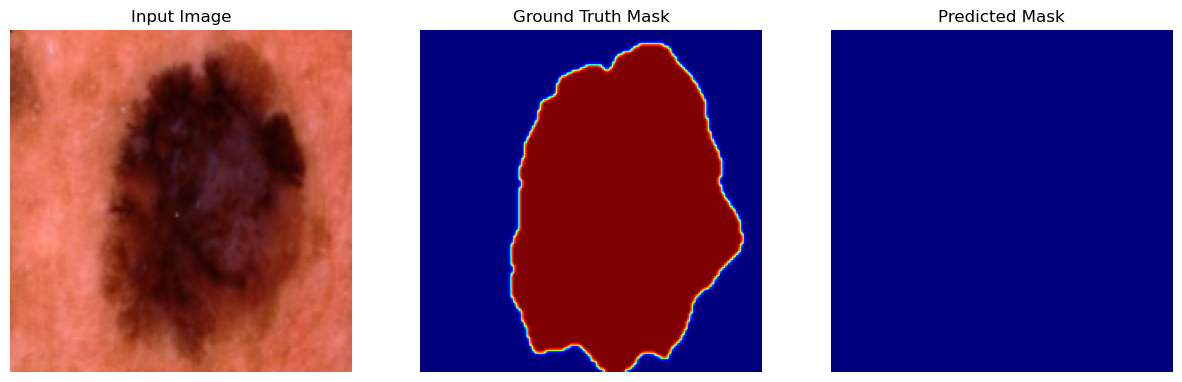

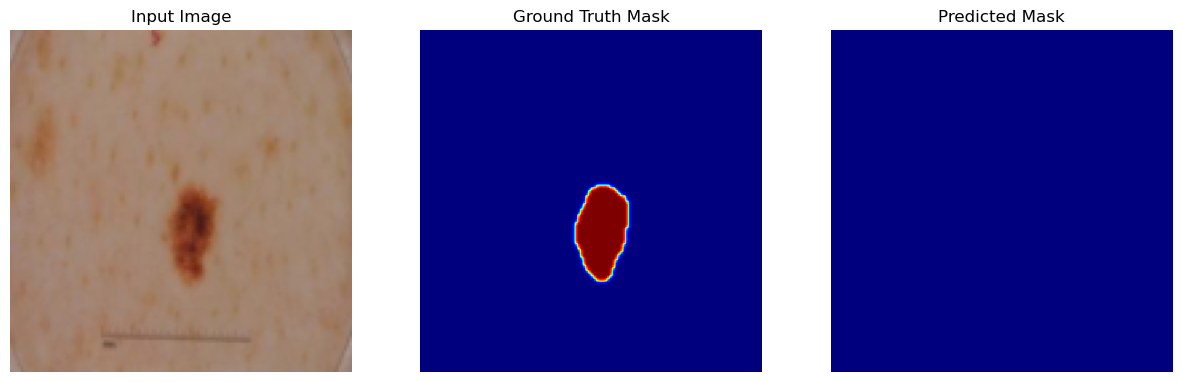

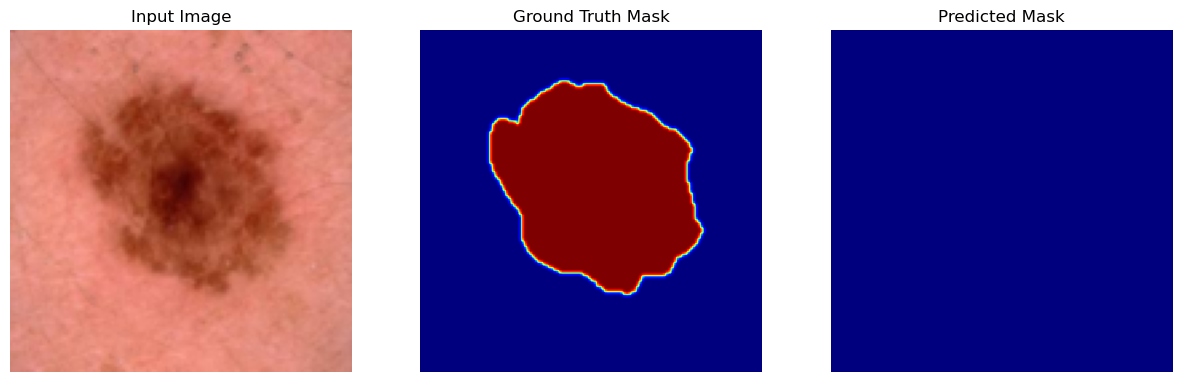

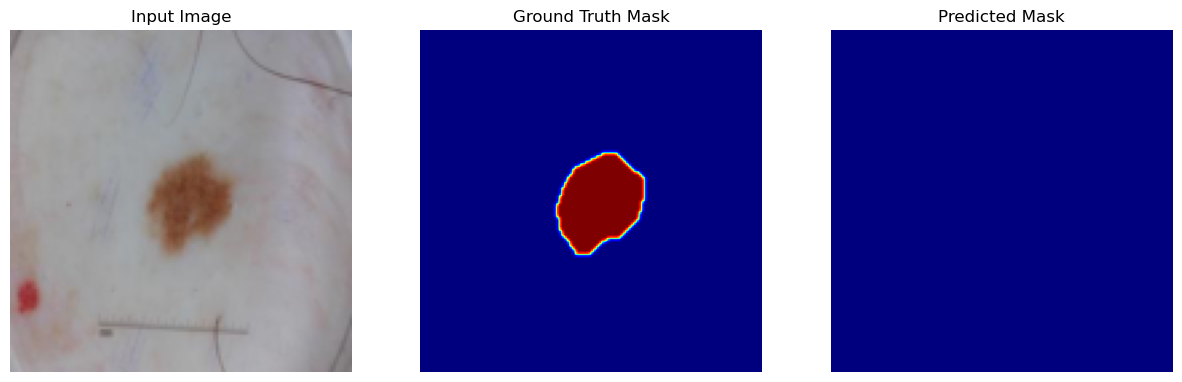

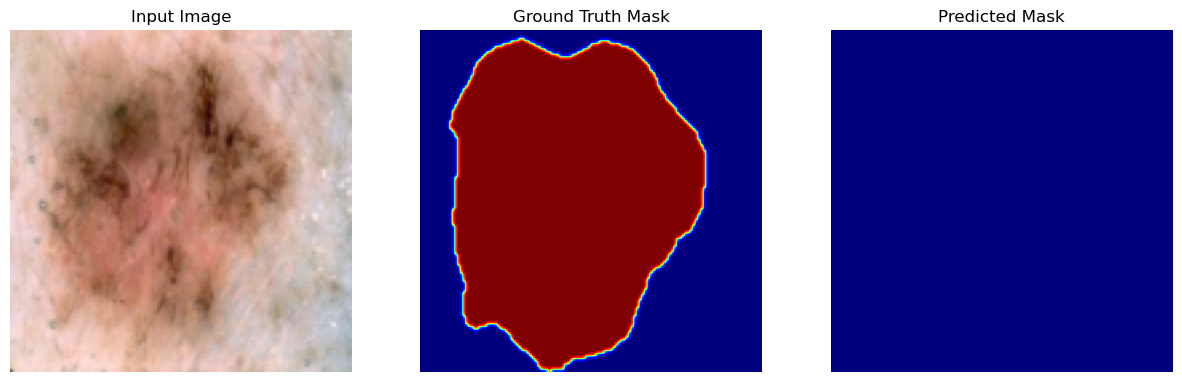

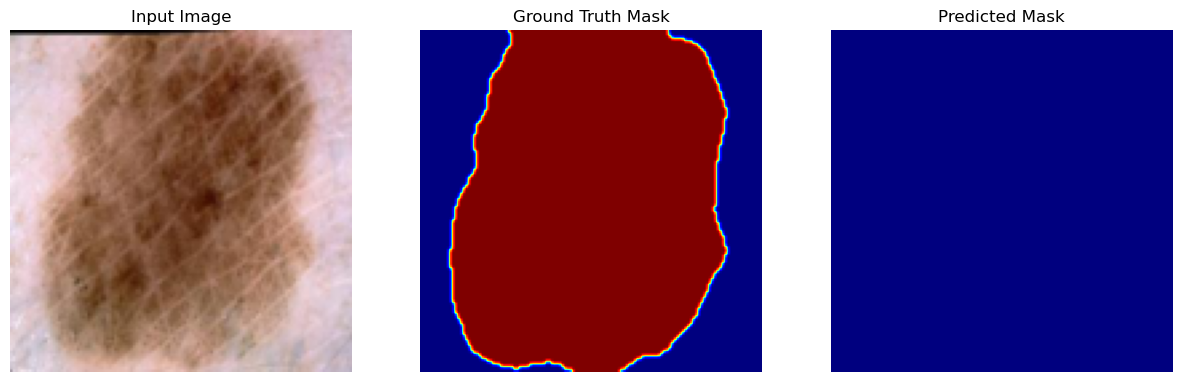

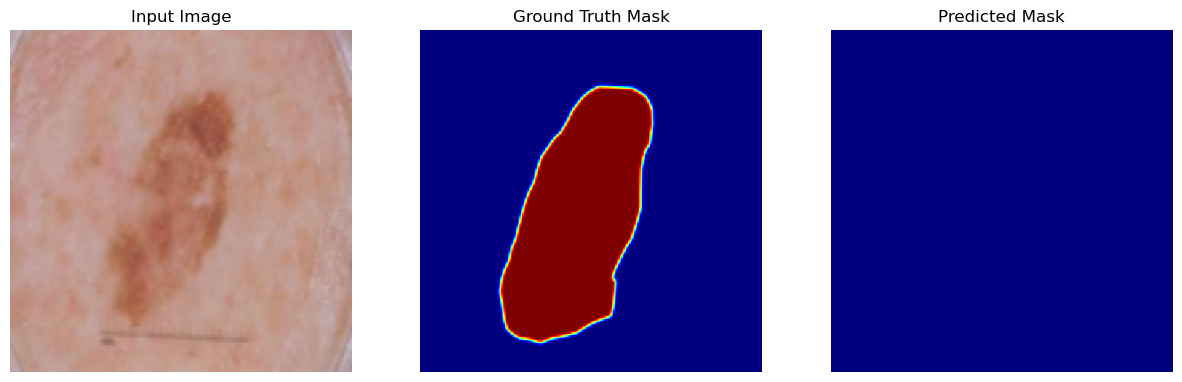

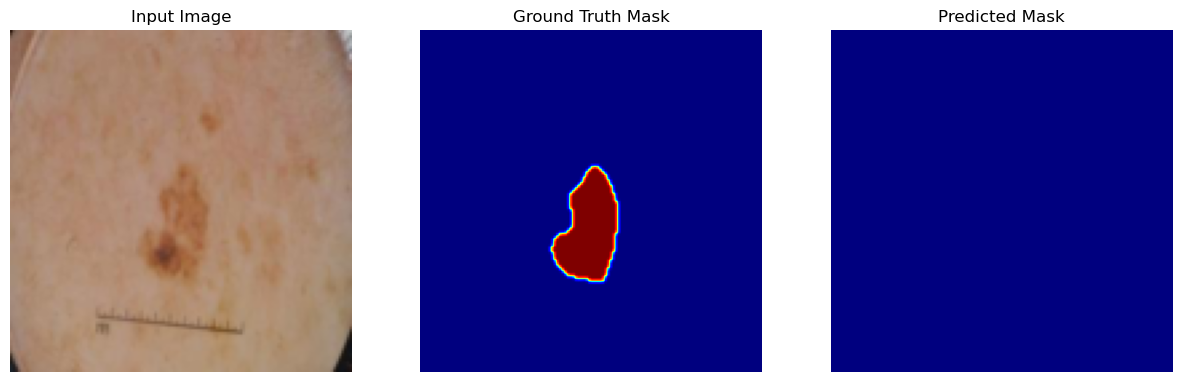

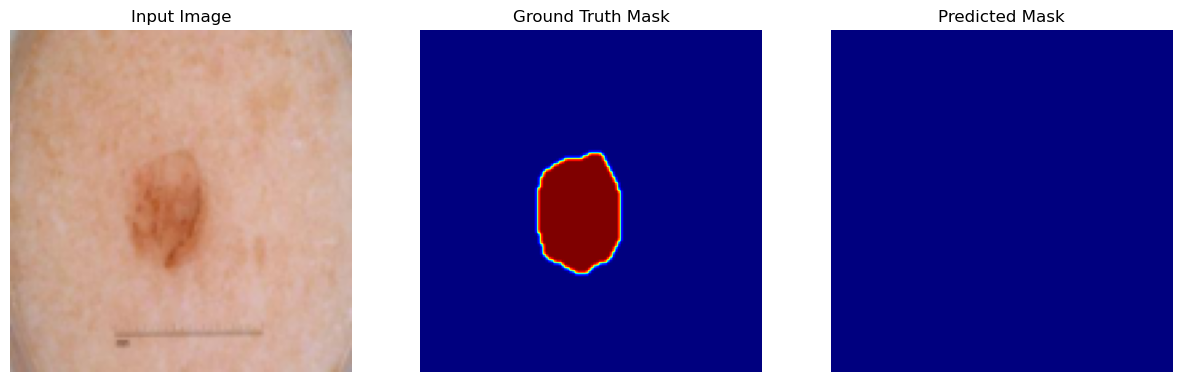

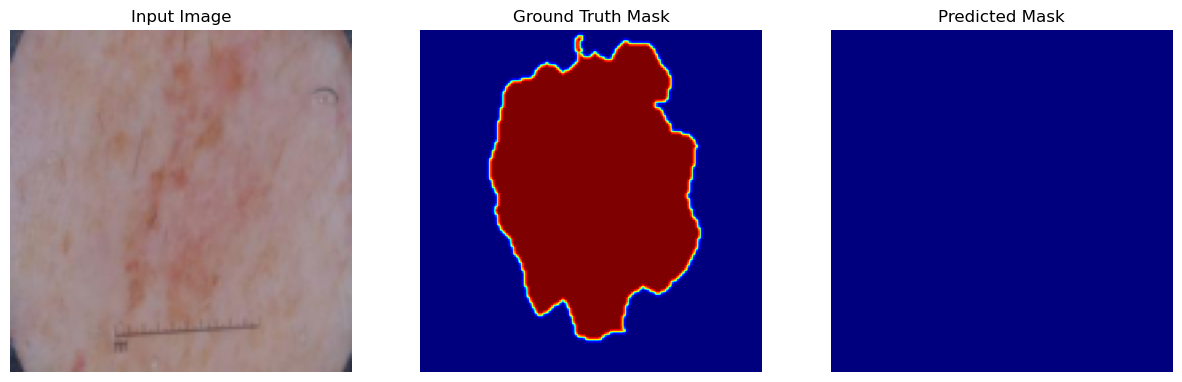

In [19]:
with torch.no_grad():
    for inputs, labels in valloader2:

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        visualize_segmentation(inputs, labels, outputs)

        #Break